### Задание к Уроку 4.
### Uplift-моделирование

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. **(опционально)** для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. **(опционально)** построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [59]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [60]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [61]:
df.treatment.value_counts()


Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [62]:
df['treatment_new'] = 1
df.loc[df.treatment == 'No Offer', 'treatment_new'] = 0
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,treatment_new
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,1
1,6,329.08,1,1,Rural,1,Web,No Offer,0,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,1


In [63]:
df.drop(columns='treatment', inplace=True)
df.rename(columns={'treatment_new': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,target,treatment
0,10,142.44,1,0,Surburban,0,Phone,0,1
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,0,1


This dataset show customer's brief information
- historical use of discount or BOGO(Buy One Get One) promotion,
- offer has been made, and the conversion result(buy or not).
- The conversion average value = $2

In [64]:
df.isna().sum()

recency          0
history          0
used_discount    0
used_bogo        0
zip_code         0
is_referral      0
channel          0
target           0
treatment        0
dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   target         64000 non-null  int64  
 8   treatment      64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [66]:
df.zip_code.value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [67]:
df.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [68]:
cat_features = ['zip_code', 'channel']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'], random_state=123, test_size=0.3)

In [70]:
treatment_train = X_train.treatment
X_train.drop(columns='treatment', inplace=True)
treatment_test = X_test.treatment
X_test.drop(columns='treatment', inplace=True)

#### Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
#### Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/

In [99]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [100]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel


#### 1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

In [101]:
# sklift поддерживает любые модели,
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treatment_train, estimator_fit_params={'cat_features': cat_features})

In [102]:
models_results['approach'].append('SoloModel')

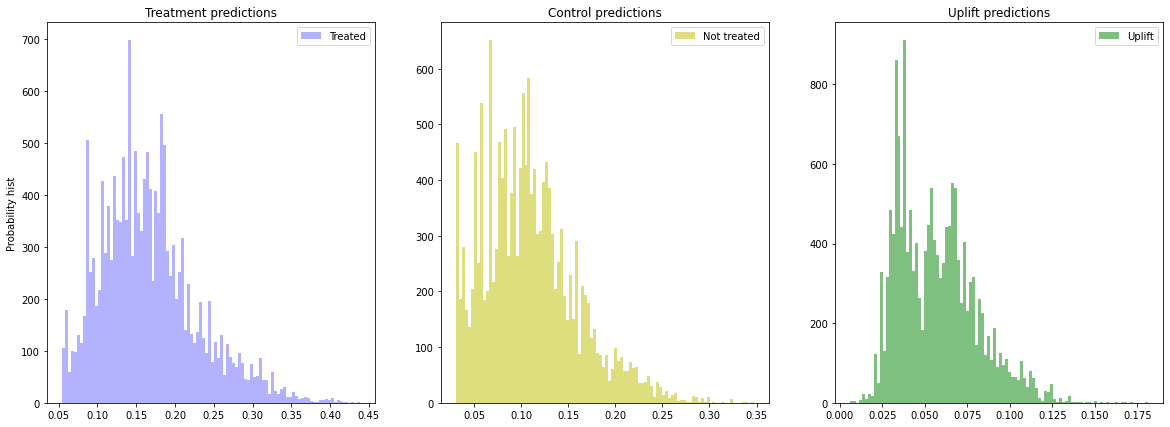

In [105]:
uplift_sm = sm.predict(X_test)
sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treatment_test, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [106]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.11780344991296093],
 'uplift@20%': [0.10496206349290041]}

#### 2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [107]:
models_results['approach'].append('ClassTransformation')

In [110]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treatment_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treatment_test, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(ct_score)

In [111]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.11780344991296093, 0.10655166956796963],
 'uplift@20%': [0.10496206349290041, 0.0862354717326008]}

#### 3 Две независимые модели
Подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

In [112]:
models_results['approach'].append('TwoModels')

In [115]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treatment_train,
    estimator_trmnt_fit_params={'cat_features': cat_features},
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)
tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treatment_test, strategy='by_group', k=0.2)


models_results['uplift@20%'].append(tm_score)

In [116]:
models_results


{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.11780344991296093, 0.10655166956796963, 0.08770375059344834],
 'uplift@20%': [0.10496206349290041, 0.0862354717326008, 0.0781920886081511]}

### Результаты

In [117]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.117803,0.104962
1,ClassTransformation,0.106552,0.086235
2,TwoModels,0.087704,0.078192
